In [79]:
# This python notebook is used for analysis and learning the different network blocks used in VIT (Vision Transformers), and also blocks specific to Hformer

# Reference implementation (that uses pytorch) : https://www.youtube.com/watch?v=j3VNqtJUoz0

# Reference for VIT impl : https://dzlab.github.io/notebooks/tensorflow/vision/classification/2021/10/01/vision_transformer.html

In [80]:
import einops

import sys
sys.path.append('../')

import tensorflow as tf
from data_importer import load_training_images
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import view_as_blocks


loaded training images x and y of len :  2 2  respectively
type of train images x :  float64
range of values in train images :  0.0 0.9804736186123806
type of train images y :  float64


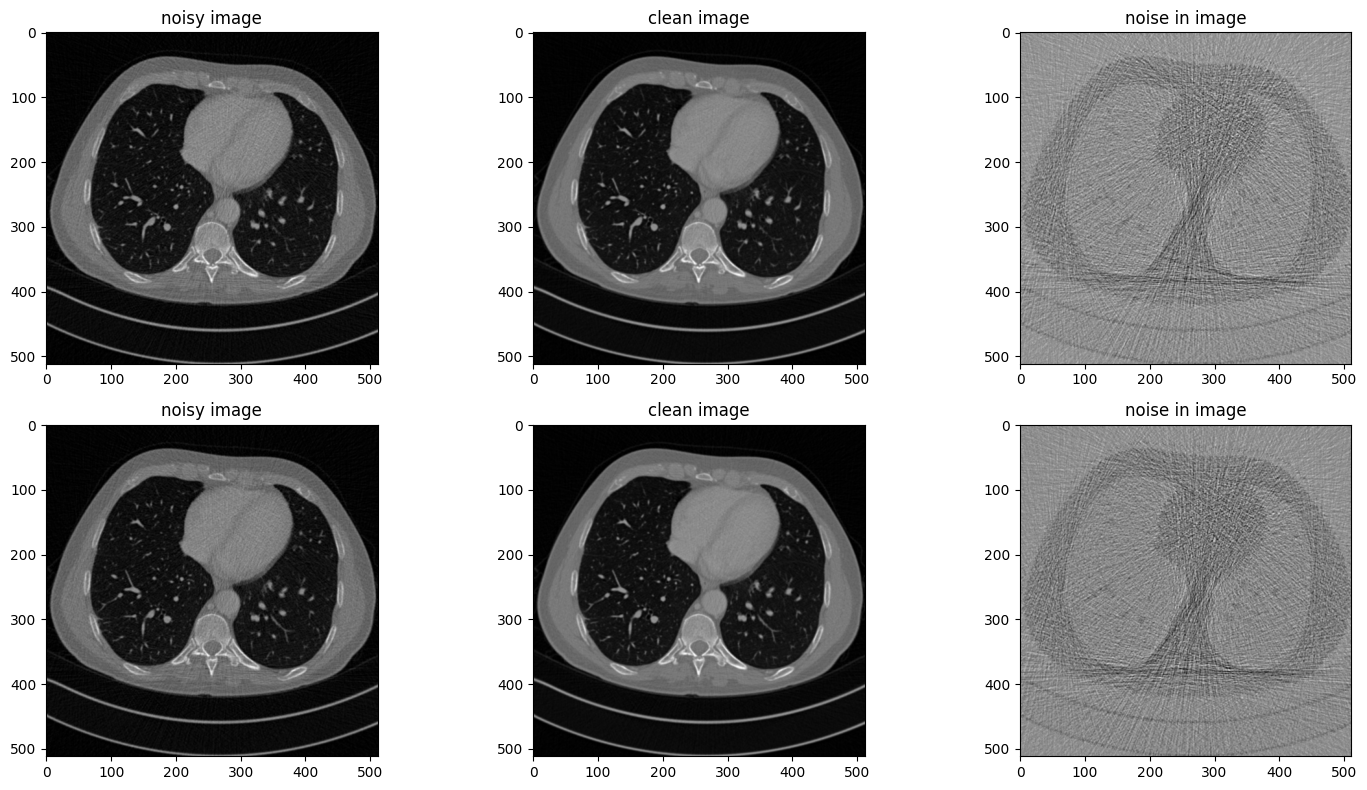

In [81]:
x_data, y_data = load_training_images('../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data/', True, 2)

f, ax = plt.subplots(len(x_data), 3, figsize=(15,8))

for i in range(len(x_data)):
    ax[i,0].set_title('noisy image')
    ax[i,0].imshow(x_data[i], cmap='gray')
    
    ax[i,1].set_title('clean image')
    ax[i,1].imshow(y_data[i], cmap='gray')
    
    ax[i,2].set_title('noise in image')
    ax[i,2].imshow(x_data[i] - y_data[i], cmap='gray')
    
    plt.plot()
    
plt.tight_layout()
plt.show()

In [82]:
# The goal of this function is to take a image as input and split it into 2D patches of given dimension.
# Note that the image dimensions must be such that patches (of same dimension) should completely cover the image.
# Returns a array of patches (in row format order)
def create_patches_from_image(image, patch_width, patch_height):
    image = image.copy()
    
    image_height, image_width, image_depth = image.shape
    if image_height % patch_height != 0 or image_width % patch_width != 0:
        print('cannot create patches of width and height : ', patch_width ,patch_height, ' for image as dimension of patches does not exactly divide image completely')

        return
    
    # Reshape the image array into 3D array where each slice represents a patch    
    # The image originally has dimension of image_width, image_height, image_depth.
    # The new shape (of patches) is num_patches_vertically, patch_height, num_patches_horizontally, patch_width, image_depth.
    patches = image.reshape(image_height // patch_height, patch_height, image_width // patch_width, patch_width, image_depth)
    
    print('shape of patches after reshaping to dimensions (num_patches_vertically, patch_height, num_patches_horizontally, patch_width, image_depth) : ', patches.shape)
    
    # Swapaxes is used to rearrange dimensions and that reshape is applied to flatten the array.
    # The swapaxes is done to swap 2nd and third dimension so that patches are grouped by horizontal order 
    # The shape is now in order : (num_patches_vertically, num_patches_horizontally, patch_height, patch_width, image_depth)
    patches = patches.swapaxes(1, 2)
    print('shape of patches after swapping axes : ', patches.shape)
    
    # Reshape is done to convert the 5D array into a 4D array of shape : (number_of_patches_flattened, patch_height, patch_width, image_depth)
    patches = patches.reshape(-1, patch_height, patch_width, image_depth)
    
    return patches

In [83]:
patches = create_patches_from_image(x_data[0], 32, 32)

print('shape of patches (resultant of the create_patches_from_image function) : ', patches.shape)

shape of patches after reshaping to dimensions (num_patches_vertically, patch_height, num_patches_horizontally, patch_width, image_depth) :  (16, 32, 16, 32, 1)
shape of patches after swapping axes :  (16, 16, 32, 32, 1)
shape of patches (resultant of the create_patches_from_image function) :  (256, 32, 32, 1)


In [84]:
def display_patches_in_grid(patches, grid_size):
    num_patches, patch_height, patch_width, image_depth = patches.shape
    
    plt.figure(figsize=(4,4))

    for i in range(min(num_patches, grid_size * grid_size)):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(patches[i], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

    plt.tight_layout(pad=0.1)
    plt.show()

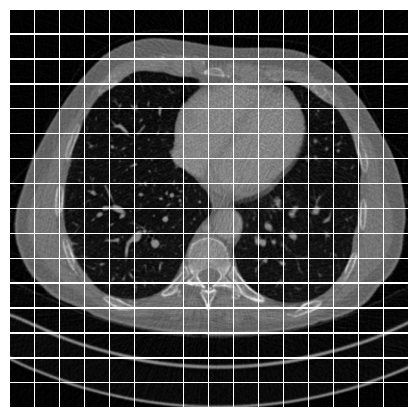

original image


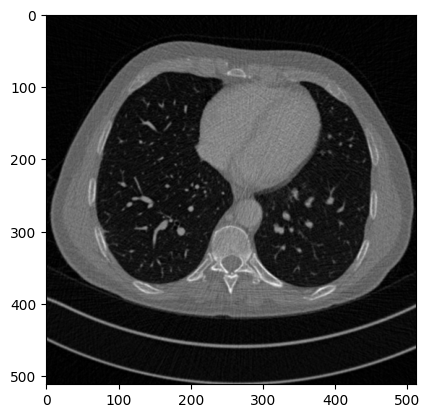

In [85]:
display_patches_in_grid(patches, 16) # 16 is number of parches vertically and horizontally
print('original image')
plt.imshow(x_data[0],cmap='gray', vmin=0, vmax=1)

In [97]:
# For sake of efficiency, tf.image has functions that will extract patches from images.
# Creating a custom layer for ease of use when creating the model.
# https://dzlab.github.io/notebooks/tensorflow/vision/classification/2021/10/01/vision_transformer.html
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self):
        super(PatchExtractor, self).__init__()

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, 32, 32, 1],
            strides=[1, 32, 32, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [98]:
batch = tf.expand_dims(x_data[0], axis=0)
patches = PatchExtractor()(batch)
patches.shape

TensorShape([1, 256, 1024])

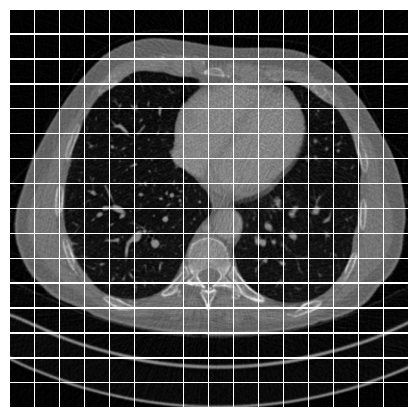

In [99]:
# Visualize these patches
    
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    plt.subplot(16, 16, i + 1)
    patch_img = tf.reshape(patch, (32, 32, 1))

    plt.imshow(patch_img.numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

plt.tight_layout(pad=0.1)
plt.show()